In [2]:
import os
from collections import defaultdict
import numpy as np
import PIL
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Bidirectional, RepeatVector, Concatenate, Activation
from tensorflow.keras.activations import softmax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.applications.inception_v3 import InceptionV3

from tensorflow.keras.optimizers import Adam

In [3]:
def load_image_list(filename):
    with open(filename,'r') as image_list_f: 
        return [line.strip() for line in image_list_f]

In [4]:
folder = 'dataset'
train_list = load_image_list(os.path.join(folder, 'Flickr_8k.trainImages.txt'))
dev_list = load_image_list(os.path.join(folder,'Flickr_8k.devImages.txt'))
test_list = load_image_list(os.path.join(folder,'Flickr_8k.testImages.txt'))

In [5]:
len(train_list), len(dev_list), len(test_list)


(6000, 1000, 1000)

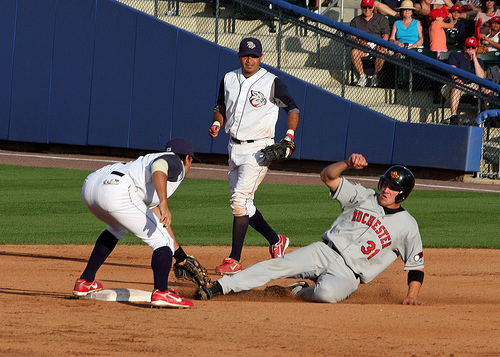

In [6]:
IMG_PATH = os.path.join(folder, "Flickr8k_Dataset")
image = PIL.Image.open(os.path.join(IMG_PATH, dev_list[100]))
image

In [7]:
def get_image(image_name):
    image = PIL.Image.open(os.path.join(IMG_PATH, image_name))
    return np.asarray(image.resize((299,299))) / 255.0  

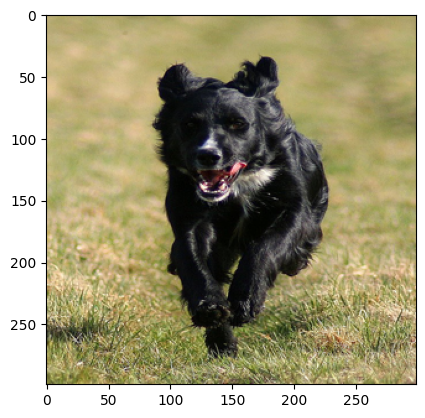

In [8]:
plt.imshow(get_image(dev_list[25]))

In [9]:
img_model = InceptionV3(weights='imagenet')
img_model.summary()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 aliza

In [10]:
new_input = img_model.input
new_output = img_model.layers[-2].output
img_encoder = Model(new_input, new_output)

In [11]:
new_image = get_image(dev_list[25])
encoded_image = img_encoder.predict(np.array([new_image]))
encoded_image

2023-09-11 21:54:32.706489: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 6s 6s/step


array([[0.32201555, 0.34690112, 0.04187513, ..., 0.06201955, 0.29855087,
        0.05849036]], dtype=float32)

In [12]:
def img_generator(img_list):
    for img_file in img_list:
        img = PIL.Image.open(os.path.join("dataset", "Flickr8k_Dataset", img_file))
        img = img.resize((299, 299))  # Resize the image to (299, 299)
        img_array = np.array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add an extra dimension for batch size
        yield img_array
        img.close()

In [14]:
enc_train = img_encoder.predict_generator(img_generator(train_list), steps=len(train_list), verbose=1)
enc_dev = img_encoder.predict_generator(img_generator(dev_list), steps=len(dev_list), verbose=1)
enc_test = img_encoder.predict_generator(img_generator(test_list), steps=len(test_list), verbose=1)

/var/folders/7w/8xc_pk4n6zg1zdkphtnj8r5c0000gn/T/ipykernel_12560/133818743.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  enc_train = img_encoder.predict_generator(img_generator(train_list), steps=len(train_list), verbose=1)


   5/1000 [..............................] - ETA: 33s 

/var/folders/7w/8xc_pk4n6zg1zdkphtnj8r5c0000gn/T/ipykernel_12560/133818743.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  enc_dev = img_encoder.predict_generator(img_generator(dev_list), steps=len(dev_list), verbose=1)


   6/1000 [..............................] - ETA: 24s

/var/folders/7w/8xc_pk4n6zg1zdkphtnj8r5c0000gn/T/ipykernel_12560/133818743.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  enc_test = img_encoder.predict_generator(img_generator(test_list), steps=len(test_list), verbose=1)


1000/1000 [==============================] - 23s 23ms/step


In [15]:
OUTPUT_PATH = "encodings" 
if not os.path.exists(OUTPUT_PATH):
    os.mkdir(OUTPUT_PATH)

np.save(os.path.join(OUTPUT_PATH,"encoded_images_train.npy"), enc_train)
np.save(os.path.join(OUTPUT_PATH,"encoded_images_dev.npy"), enc_dev)
np.save(os.path.join(OUTPUT_PATH,"encoded_images_test.npy"), enc_test)    

In [15]:
#load image captions

def read_image_descriptions(filename):    
    image_descriptions = defaultdict(list)   
    
    with open(filename,'r') as f:
        for line in f:
            image_name, image_description = line.strip().split('\t')
            #print(image_name[:-2], "<START> " + image_description.lower() + " <END>")
            sequence = "<START> " + image_description.lower() + " <END>"
            image_descriptions[image_name[:-2]].append(sequence.split())

    return image_descriptions

descriptions = read_image_descriptions("dataset/Flickr8k.token.txt")
print(descriptions[dev_list[0]])


[['<START>', 'the', 'boy', 'laying', 'face', 'down', 'on', 'a', 'skateboard', 'is', 'being', 'pushed', 'along', 'the', 'ground', 'by', 'another', 'boy', '.', '<END>'], ['<START>', 'two', 'girls', 'play', 'on', 'a', 'skateboard', 'in', 'a', 'courtyard', '.', '<END>'], ['<START>', 'two', 'people', 'play', 'on', 'a', 'long', 'skateboard', '.', '<END>'], ['<START>', 'two', 'small', 'children', 'in', 'red', 'shirts', 'playing', 'on', 'a', 'skateboard', '.', '<END>'], ['<START>', 'two', 'young', 'children', 'on', 'a', 'skateboard', 'going', 'across', 'a', 'sidewalk', '<END>']]
